## Import Libraries

In [1]:
import os
import gdown
import zipfile
import numpy as np
import shutil
import tensorflow as tf
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

## Dataset

In [2]:
!gdown --id 1f1oJvIajWvE59LATHeewtw20XwrGMXAF


/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1f1oJvIajWvE59LATHeewtw20XwrGMXAF
From (redirected): https://drive.google.com/uc?id=1f1oJvIajWvE59LATHeewtw20XwrGMXAF&confirm=t&uuid=b376a4d3-90ef-4c78-877a-f1a4a6db97c0
To: /content/skinimage.zip
100% 40.3M/40.3M [00:00<00:00, 47.0MB/s]


In [3]:
# Path file ZIP yang sudah diunduh
zip_path = "/content/skinimage.zip"

# Path folder tujuan ekstraksi
extract_path = "/content/dataskin"

# Ekstraksi file
if zip_path.endswith(".zip"):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"Dataset berhasil diekstrak ke {extract_path}")

# Menampilkan nama folder dan 10 gambar pertama dari setiap folder
    print("\nStruktur folder dan gambar pertama:")
    for class_name in ['berminyak', 'kering', 'normal']:
        class_path = os.path.join(extract_path, class_name)

        if os.path.isdir(class_path):
            print(f"\n{class_name}/")
            images = os.listdir(class_path)
            for i, image in enumerate(images[:10]):  # Menampilkan hanya 10 gambar pertama
                print(f"    {image}")


Dataset berhasil diekstrak ke /content/dataskin

Struktur folder dan gambar pertama:

berminyak/
    berminyak (332).jpg
    berminyak (212).jpg
    berminyak (158).jpg
    berminyak (151).jpg
    berminyak (153).jpg
    berminyak (346).jpg
    berminyak (215).jpg
    berminyak (289).jpg
    berminyak (79).jpg
    berminyak (23).jpg

kering/
    kering (136).jpeg
    kering (95).jpeg
    kering (130).jpg
    kering (129).jpg
    kering (200).jpeg
    kering (5).jpeg
    kering (72).jpg
    kering (77).jpg
    kering (154).jpeg
    kering (36).jpg

normal/
    normal (371).jpg
    normal (315).jpg
    normal (240).jpg
    normal (108).jpg
    normal (372).jpg
    normal (239).jpg
    normal (168).jpg
    normal (299).jpg
    normal (24).jpg
    normal (367).jpg


## **Preprocessing**

## Split Dataset

In [4]:
# Path file ZIP yang sudah diunduh
zip_path = "/content/skinimage.zip"

# Path folder tujuan ekstraksi
extract_path = "/content/dataskin"

# Ekstraksi file ZIP
if zip_path.endswith(".zip"):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"Dataset berhasil diekstrak ke {extract_path}")

# Path untuk menyimpan dataset yang telah dibagi
base_dir = "/content/dataset_splitting"
os.makedirs(base_dir, exist_ok=True)

# Buat folder untuk train, val, test
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Membuat subfolder untuk train, val, test
for folder in [train_dir, val_dir, test_dir]:
    os.makedirs(folder, exist_ok=True)

# Daftar folder kelas yang relevan
classes = ['berminyak', 'kering', 'normal']

# Membagi dataset untuk setiap kelas
for class_name in classes:
    class_dir = os.path.join(extract_path, class_name)

    # Pastikan hanya folder yang ada
    if os.path.isdir(class_dir):
        print(f"\nMembagi dataset untuk kelas: {class_name}")

        # Ambil semua gambar dalam folder kelas
        images = os.listdir(class_dir)
        images = [os.path.join(class_dir, img) for img in images]

        # Bagi dataset menjadi train (70%), val (15%), test (15%)
        train_imgs, test_imgs = train_test_split(images, test_size=0.3, random_state=42)
        val_imgs, test_imgs = train_test_split(test_imgs, test_size=0.5, random_state=42)

        # Buat subfolder untuk kelas di train, val, test
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

        # Pindahkan gambar ke folder yang sesuai
        for img in train_imgs:
            shutil.copy(img, os.path.join(train_dir, class_name))
        for img in val_imgs:
            shutil.copy(img, os.path.join(val_dir, class_name))
        for img in test_imgs:
            shutil.copy(img, os.path.join(test_dir, class_name))

print("Dataset telah dibagi menjadi training, validation, dan testing.")


Dataset berhasil diekstrak ke /content/dataskin

Membagi dataset untuk kelas: berminyak

Membagi dataset untuk kelas: kering

Membagi dataset untuk kelas: normal
Dataset telah dibagi menjadi training, validation, dan testing.


In [5]:
# Training dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    seed=123,
    image_size=(224, 224),
    batch_size=64,
    label_mode="categorical"
)

# Validation dataset
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    seed=123,
    image_size=(224, 224),
    batch_size=64,
    label_mode="categorical"
)

# Test dataset
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=123,
    image_size=(224, 224),
    batch_size=64,
    label_mode="categorical"
)


Found 890 files belonging to 3 classes.
Found 191 files belonging to 3 classes.
Found 192 files belonging to 3 classes.


## Normalization Dataset

In [6]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
normalized_val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
normalized_test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

## Optimize Dataset

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)

## Augmentation Data

In [8]:
for images, labels in train_dataset.take(1):
  example_batch_images = images
  example_batch_labels = labels

print(f"Each images has shape: {example_batch_images.shape}")
print(f"Each labels has shape: {example_batch_labels.shape}")

Each images has shape: (64, 224, 224, 3)
Each labels has shape: (64, 3)


In [9]:
# Data Augmentation model
FILL_MODE = 'nearest'

data_augmentation = tf.keras.Sequential([
        tf.keras.Input(shape=(224, 224, 3)),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2, fill_mode=FILL_MODE),
        tf.keras.layers.RandomTranslation(0.2, 0.2, fill_mode=FILL_MODE),
        tf.keras.layers.RandomZoom(0.2, fill_mode=FILL_MODE),
        tf.keras.layers.RandomContrast(0.2)
        ])

## Create Model

In [10]:
def create_model():
    base_model = ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(3, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [11]:
model = create_model()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,850,371 (90.98 MB)

 Trainable params: 262,659 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [13]:
# Train model
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset
                    )

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 224s 16s/step - accuracy: 0.3775 - loss: 1.7091 - val_accuracy: 0.5079 - val_loss: 1.0032
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 268s 16s/step - accuracy: 0.4095 - loss: 1.2641 - val_accuracy: 0.6492 - val_loss: 0.8225
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 258s 16s/step - accuracy: 0.5412 - loss: 1.0031 - val_accuracy: 0.6859 - val_loss: 0.7422
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 265s 16s/step - accuracy: 0.5783 - loss: 0.8931 - val_accuracy: 0.7173 - val_loss: 0.6876
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 214s 15s/step - accuracy: 0.6224 - loss: 0.8387 - val_accuracy: 0.7487 - val_loss: 0.6546
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 262s 16s/step - accuracy: 0.6701 - loss: 0.7586 - val_accuracy: 0.7696 - val_loss: 0.6309
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 272s 16s/step - accuracy: 0.7145 - loss: 0.6544 - val_accuracy: 0.7853 - val_loss: 0.6037
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 250s 15s/step - accuracy: 0.7529 - loss: 0.6177 - val_accuracy: 0.

## Model Evaluation

In [14]:
loss, accuracy = model.evaluate(val_dataset)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 40s 13s/step - accuracy: 0.8655 - loss: 0.3621
Validation Loss: 0.3686758577823639
Validation Accuracy: 0.8638743162155151


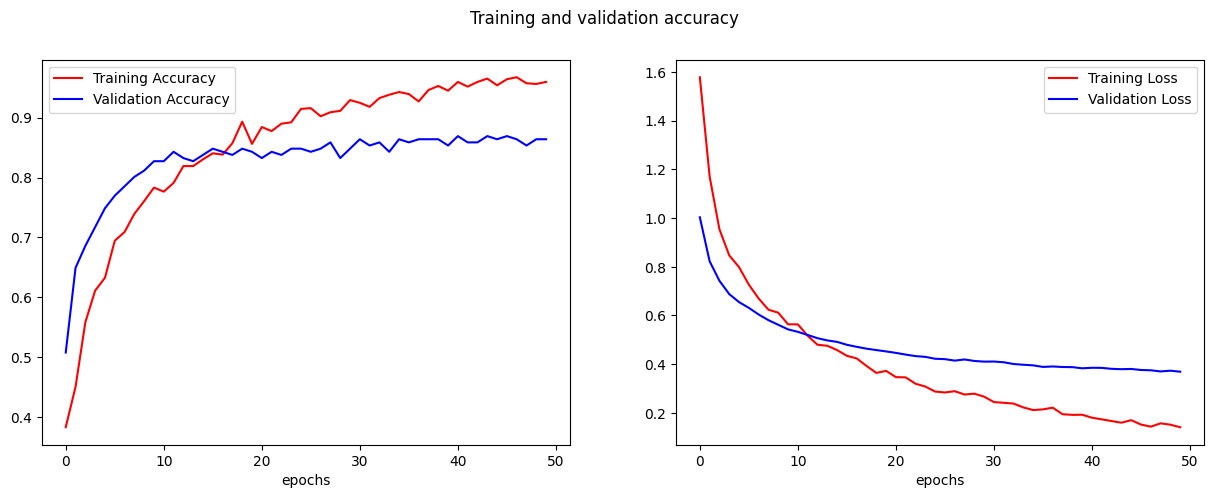

In [15]:
# akurasi training dan validasi
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()